<a href="https://colab.research.google.com/github/yuvalofek/FinancialSignalProcessing/blob/main/FSP3_Stochastic_Calc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating Stochastic Differential Equations & the Cox-Ingersoll-Ross Interest Rate Model

##Simulating Stochastic Differential Equations

In [ ]:
#imports 
import numpy as np
from scipy.stats import norm 
import matplotlib.pyplot as plt
import pandas as pd
import warnings


In [ ]:
#Constants:
SEED = 1234
delta = 0.01
N = 250
S_0= 1 
alpha = 0.1
sigma = 0.2
r = 0.05

###(a)
\begin{equation}
dS_t = \alpha S_tdt + \sigma S_tdW_t \\
r \; constant   \implies D(t) = e^{-rt},\; R(t) = r \\
We\;know\;that: dS(t) = R(t)S(t)dt+\sigma(t)S(t)d \tilde(W)(t) \\ 
\implies dS_t = rS_tdt + \sigma S_t d\tilde{W}_t
\end{equation}


In [ ]:
def get_paths_BM (N_paths, alpha, sigma, S_0 = S_0, delta = delta, N = N, Seed = SEED):
  ##Return N_paths different paths of the stochastic differential equation above, 
  # each of length N. 

  #seed
  np.random.seed(SEED)
  #Randomly select the dW's 
  dws = np.random.normal(scale = np.sqrt(delta), size = (N_paths, N))

  #sum to calculate the S_n values
  S = np.ones((N_paths, N))*S_0
  for i in range(1,N):
    S_i = S[:,i-1]*alpha*delta + S[:,i-1]*dws[:,i-1]*sigma
    S[:,i:] += S_i.reshape(-1,1)
  return S

In [ ]:
###(b)
N_paths = 1_000
paths = get_paths_BM(N_paths, alpha, sigma)

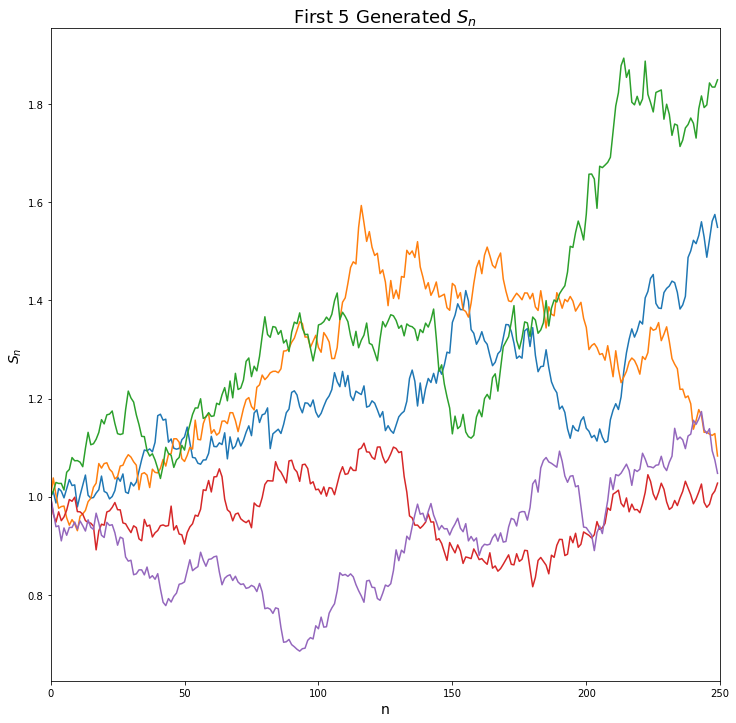

In [ ]:
#Plotting some of the Sn
plt.figure(figsize = (12,12))
for i in range(5):
  plt.plot(paths[i,:])
plt.xlabel('n', fontsize = 14)
plt.ylabel('$S_n$', fontsize = 14)
plt.title('First 5 Generated $S_n$', fontsize = 18)
plt.xlim(0, N)
plt.show()

In [ ]:
def MC_E(values):
  #Monte Carlo Estimate of the expectation over method used to generate Sn
  return np.nanmean(values)

In [ ]:
###(c)
#I interpreted the question as using the risk neutral method to take the 
# expectations.

#setting alpha = r gives us the SDE under the risk Neutral Method
# --> We get the Expectation wrt the risk neutral
pathsRN = get_paths_BM(N_paths, r, sigma)
E_end = MC_E(pathsRN[:,-1])
E_half = MC_E(pathsRN[:,int(N/2)])

In [ ]:
def call_BSM(tau ,x, K, r, sigma):
  d1 = (np.log(x / K) + (r + 0.5 * sigma ** 2) * tau) / (sigma * np.sqrt(tau))
  d2 = d1- sigma*np.sqrt(tau)
  return  x * norm.cdf(d1) - K * np.exp(-r * tau) * norm.cdf(d2)

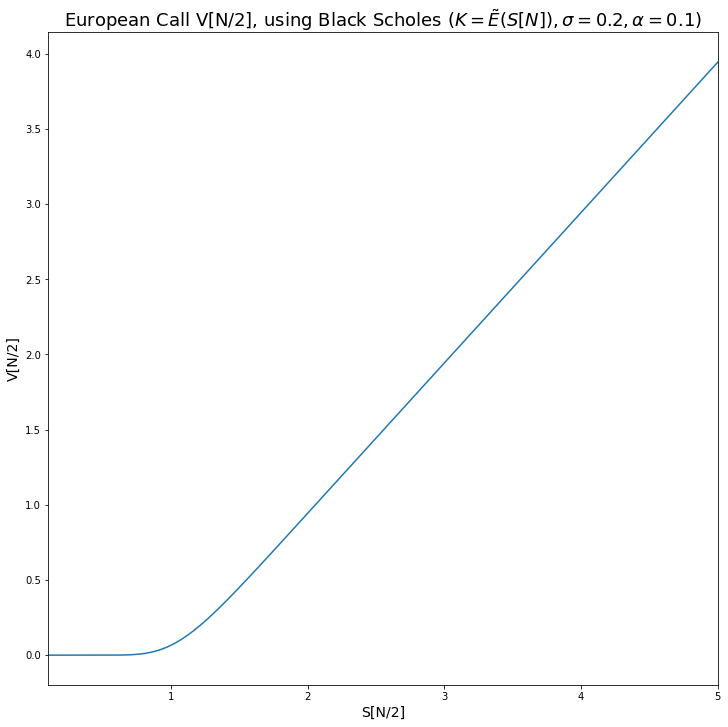

In [ ]:
###(d)
Sn_min = 1e-1
Sn_max = 5
T = delta*N
Sn_range = np.linspace(Sn_min, Sn_max, N)

VN2= call_BSM(T/2,Sn_range, K =  E_end, r = r, sigma = sigma)



plt.figure(figsize = (12,12))
plt.plot(Sn_range, VN2)
plt.ylabel('V[N/2]', fontsize = 14)
plt.xlabel('S[N/2]', fontsize = 14)
plt.title(r'European Call V[N/2], using Black Scholes ($K=\tilde{E}(S[N]), \sigma=0.2, \alpha = 0.1$)', fontsize = 18)
plt.xlim(Sn_min, Sn_max)
plt.show()

In [ ]:
def call(S,K):
  #European Call Option
  return np.maximum(0, S-K)
def D(t, r = r):
  return np.exp(-r*t)

In [ ]:
### (e)
paths10 = paths[:10, :]

#Black-Scholes
BSM10 = call_BSM(T/2,paths10[:, int(N/2)], K =  E_end, r = r, sigma = sigma)

#MC:
N_paths = 1_000
new_paths = np.zeros((N_paths, 10))
for i, Sno2 in enumerate(paths10[:, int(N/2)]):
  #Expanding paths from S[N/2] to S[N] using the risk neutral measure
  #Note that we only care about S[N], so we save only that
  new_paths[:,i] = get_paths_BM (N_paths, r, sigma, S_0 = Sno2, delta = delta, N = int(N/2), Seed = SEED)[:,-1]
VN_ = call(new_paths, E_end)
MC10 = np.mean(VN_*D(T,r), axis = 0)/D(T/2, r)



In [ ]:
tb = pd.DataFrame([paths10[:, int(N/2)],BSM10, MC10] ).T
tb.columns = ['S[N/2]', 'Black-Scholes V[N/2]', 'Monte-Carlo V[N/2]']
tb

,S[N/2],Black-Scholes V[N/2],Monte-Carlo V[N/2]
0,1.134700,0.142299,0.135529
1,1.437472,0.392720,0.382561
2,1.345974,0.309407,0.299917
3,1.068900,0.101553,0.094953
4,0.820033,0.013456,0.010422
5,1.663712,0.610785,0.600389
6,1.544858,0.494797,0.484389
7,1.078687,0.107183,0.100505
8,1.121135,0.133360,0.126646
9,1.493197,0.445253,0.434847


## 2. Cox-Ingersoll-Ross Interest Rate Mode

In [ ]:
#constants
beta = 1
alpha = 0.1*beta
r = 0.05
sigma = 0.5
T = 10
N = T/delta

In [ ]:
def get_paths_Rate (N_paths, alpha, beta, sigma, r = r, delta = delta, N = N, Seed = SEED):
  warnings.filterwarnings('ignore')
  ##Return N_paths different paths of the rate SDE above, each of length N. 

  #seed
  np.random.seed(SEED)
  #Randomly select the dW's 
  dws = np.random.normal(scale = np.sqrt(delta), size = (N_paths, N))

  #sum to calculate the S_n values
  R = np.ones((N_paths, N))*r
  for i in range(1,N):
    R_i = (alpha-beta*R[:,i-1])*delta + np.sqrt(R[:,i-1])*dws[:,i-1]*sigma
    R[:,i:] += R_i.reshape(-1,1)

  #Once R<0 we get nans because of the sqrt, so I deal with them after the fact 
  #rather than halting. I decided to keep the nans as it makes for simpler 
  #code later. I also make the negative values nans:
  #R[np.isnan(R)] = 0
  #Note: Halting the each row would actually make later calculations harder, 
  #because of the initialization. 
  R[R<=0] = np.nan

  if np.isnan(R).any():
    print('R(t)<=0 occured!')
  return R

R(t)<=0 occured!


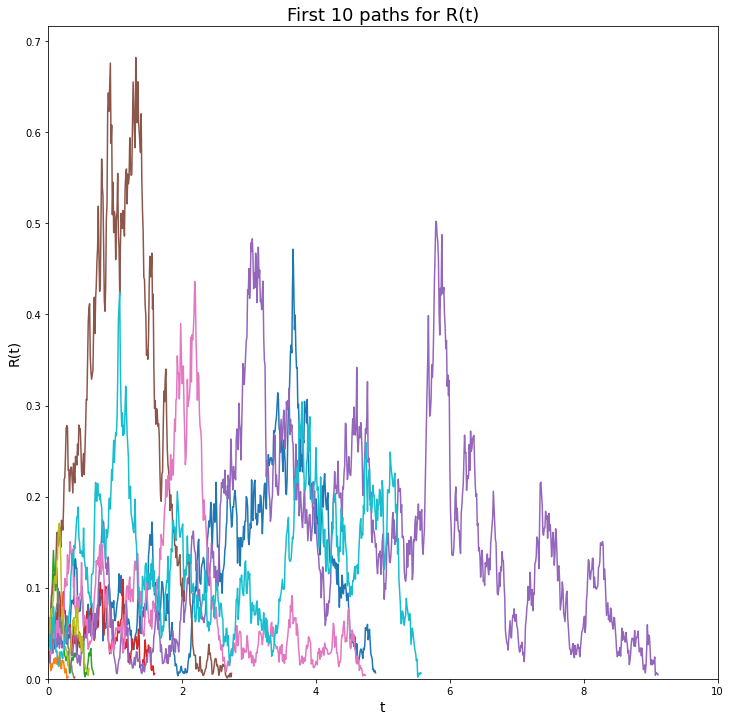

In [ ]:
R_paths = get_paths_Rate (N_paths, alpha, beta, sigma, r = r, N = int(N))

plt.figure(figsize=(12,12))
t = [i*delta for i in range(int(N))]
for i in range(10):
  plt.plot(t, R_paths[i,:])
plt.xlabel('t', fontsize = 14)
plt.ylabel('R(t)', fontsize = 14)
plt.title('First 10 paths for R(t)', fontsize = 18)
ymn, ymx = plt.ylim()
plt.ylim(0, ymx)
plt.xlim(0,T)
plt.show()


We can see that most of the R(t) end up 'halting' due to $ R \leq 0$. 


In [ ]:
theory = [alpha/beta, alpha*sigma**2/(2*beta**2)]
t1 = [MC_E(R_paths[:,int(1/delta)]), np.nanvar(R_paths[:,int(1/delta)])]
t10 = [MC_E(R_paths[:,-1]),np.nanvar(R_paths[:,-1]) ]

In [ ]:
table = pd.DataFrame([theory, t1,t10])
table.columns = ['E(R(t))', 'var(R(t))']
table.index = ['Theory', 't=1', 't=10']
table

,E(R(t)),var(R(t))
Theory,0.100000,0.012500
t=1,0.107739,0.009314
t=10,0.156605,0.014826


It seems like the mean estimations were much better than the variance. This is very likely because not enough paths reached t=1 and t=10, and so the estimations used weren't very good. 